In [1]:
import torch
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig
import pandas as pd
import ast
import time
import re
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments, GenerationConfig
from datasets import Dataset, load_dataset, load_from_disk
from peft import LoraConfig, get_peft_model, PeftConfig, PeftModel, prepare_model_for_kbit_training
from trl import SFTTrainer
from accelerate import FullyShardedDataParallelPlugin, Accelerator
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)
from datetime import datetime
now = datetime.now()

base_model_id = "mistralai/Mistral-7B-Instruct-v0.1"
# base_model_id = "mistralai/Mistral-7B-v0.1"

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
    padding='max_length',
    max_length=512,
    truncation=True
)
tokenizer.pad_token = tokenizer.eos_token

hf_dset = hf_dset = load_from_disk('./hf_dset/')

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,            # load model in 4-bit precision
    bnb_4bit_quant_type="nf4",    # pre-trained model should be quantized in 4-bit NF format
    bnb_4bit_use_double_quant=True, # Using double quantization as mentioned in QLoRA paper
    bnb_4bit_compute_dtype=torch.bfloat16, # During computation, pre-trained model should be loaded in BF16 format
)

# auto maps to GPUs shouldn't matter since I only have 1, trust_remote_code is for custom defined models to pull from HF hub
model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, trust_remote_code=True)

# use CPU to prevent OOM
fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

# please take care of model memory management for me
accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

# also helps memory 
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

# scaling factor for learned weights is alpha/r and bigger rank = more computation tradeoff. paper did 64/16=8, we'll try 16/2=8
config = LoraConfig(
    r=2,
    lora_alpha=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

# prep model for qlora
model = get_peft_model(model, config)

# Apply the accelerator.
model = accelerator.prepare_model(model)

training_arguments = TrainingArguments(
        output_dir=f"./model_ft_{now.strftime('%m.%d.%H')}",
        warmup_steps=2,
        per_device_train_batch_size=2, # reduce if OOM by 2x
        gradient_accumulation_steps=4, # x 2x if batch size is reduced
        max_steps=1000,
        learning_rate=2.5e-5, # Want about 10x smaller than the Mistral learning rate
        logging_steps=10,
        logging_dir="./logs", # Directory for storing logs
        fp16 = False,
        bf16 = True, # With an A100
        optim="paged_adamw_8bit", 
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=50,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
    )

# using SFTTrainer instead of Trainer() because huggingface recommends its use for this exact purpose
trainer = SFTTrainer(
    model=model,
    train_dataset=hf_dset['train'],
    eval_dataset=hf_dset['test'],
    dataset_text_field='formatted_pretoken_input',
    data_collator=None,
    max_seq_length=512,
    tokenizer=tokenizer,
    args=training_arguments,
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
model.to(accelerator.device)

trainer.train()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/793 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
25,3.094000,2.904192
50,2.810700,2.736050
75,2.687100,2.640629
100,2.571600,2.601024
125,2.597200,2.573185
150,2.559100,2.551162
175,2.557400,2.529071
200,2.485200,2.511923
225,2.462500,2.494636
250,2.522400,2.490737


TrainOutput(global_step=1000, training_loss=2.491051027297974, metrics={'train_runtime': 22794.3861, 'train_samples_per_second': 0.351, 'train_steps_per_second': 0.044, 'total_flos': 1.5994318363617485e+17, 'train_loss': 2.491051027297974, 'epoch': 1.12})

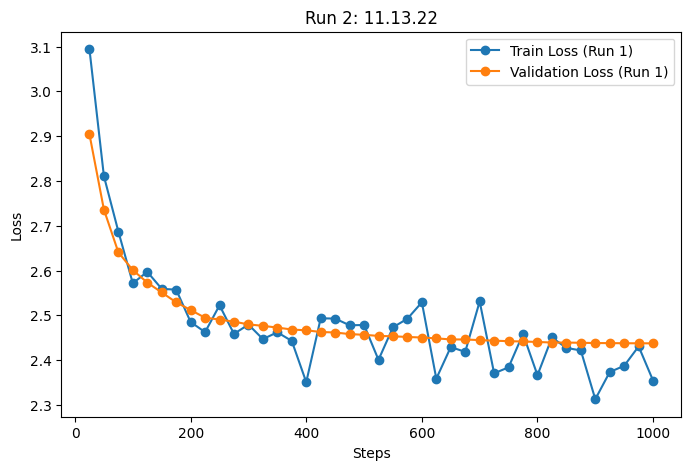

In [1]:
import matplotlib.pyplot as plt

# Data for the second run (11.13.22)
steps_2 = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
train_loss_2 = [3.094000, 2.810700, 2.687100, 2.571600, 2.597200, 2.559100, 2.557400, 2.485200, 2.462500, 2.522400, 2.458600, 2.479400, 2.447000, 2.462200, 2.442800, 2.350900, 2.493400, 2.492800, 2.477800, 2.478500, 2.400700, 2.473300, 2.492500, 2.529100, 2.358700, 2.429200, 2.418500, 2.531100, 2.370600, 2.384000, 2.458500, 2.366400, 2.450600, 2.427300, 2.421700, 2.312800, 2.373500, 2.387400, 2.430700, 2.354300]
eval_loss_2 = [2.904192, 2.736050, 2.640629, 2.601024, 2.573185, 2.551162, 2.529071, 2.511923, 2.494636, 2.490737, 2.485853, 2.479867, 2.476539, 2.472702, 2.468374, 2.466607, 2.462936, 2.461704, 2.458230, 2.456557, 2.454125, 2.453269, 2.451760, 2.450514, 2.448604, 2.446296, 2.446135, 2.444722, 2.443490, 2.442349, 2.441643, 2.440591, 2.439392, 2.439248, 2.438788, 2.438208, 2.438012, 2.437763, 2.437620, 2.437542]

# Plotting run
plt.figure(figsize=(8, 5))
plt.plot(steps_2, train_loss_2, label='Train Loss (Run 1)', marker='o')
plt.plot(steps_2, eval_loss_2, label='Validation Loss (Run 1)', marker='o')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Run 2: 11.13.22')
plt.legend()
plt.show()


## Initial Eval

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel

base_model_id='mistralai/Mistral-7B-Instruct-v0.1'
PEFT_MODEL = 'model_ft_11.13.22/checkpoint-1000'

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,            # load model in 4-bit precision
    bnb_4bit_quant_type="nf4",    # pre-trained model should be quantized in 4-bit NF format
    bnb_4bit_use_double_quant=True, # Using double quantization as mentioned in QLoRA paper
    bnb_4bit_compute_dtype=torch.bfloat16, # During computation, pre-trained model should be loaded in BF16 format
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
ft_model = PeftModel.from_pretrained(base_model, PEFT_MODEL)

# base_model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
from datasets import load_from_disk

hf_dset = load_from_disk('./hf_dset/')

custom_eval = ["what's your favorite line traveling circus episode?",
               "how do you get to chad's gap from the bottom of alta?",
               "what new movie are you going to see this year?",
               "how is the durability of line skis?",
               "where should I go to college?",
               "What's your favorite segment of all time?",
               "what do you think of armada?",
               "what do you think of the game shredsauce?",
               "who would win in a game of slvsh, will wesson or andy parry?",
               "what place did lj get in xgames realski?",
               "What are Tanner Hall's biggest accomplishments?",
               "Should Henrik focus on filming or contests?"
               ]

eval_ex = [s.split("[INST]", 1)[1].split("[/INST]", 1)[0] if "[INST]" in s and "[/INST]" in s else s for s in hf_dset['test']['formatted_pretoken_input'][:30]]
eval_ans = [s.split("[INST]", 1)[1].split("[/INST]", 1)[1] if "[INST]" in s and "[/INST]" in s else "" for s in hf_dset['test']['formatted_pretoken_input'][:30]]


In [3]:
# base model outputs
bm_outs = []

for i, ex in enumerate(eval_ex):
    prompt = "[INST] " + ex + " [/INST]"
    model_input = tokenizer(prompt, return_tensors="pt").to("cuda")
    bm_out = tokenizer.decode(base_model.generate(**model_input, max_new_tokens=200, pad_token_id=2, repetition_penalty=1.15)[0], skip_special_tokens=True)
    bm_outs.append(bm_out.split("[/INST]", 1)[-1].replace('\n', '').replace('[INST]', ''))

In [4]:
# finetuned model outputs
ft_model = PeftModel.from_pretrained(base_model, PEFT_MODEL)
ft_model.eval()

ft_outs = []

for i, ex in enumerate(eval_ex):
    prompt = "[INST] " + ex + " [/INST]"
    model_input = tokenizer(prompt, return_tensors="pt").to("cuda")
    ft_out = tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=200, pad_token_id=2, repetition_penalty=1.15)[0], skip_special_tokens=True)
    ft_outs.append(ft_out.split("[/INST]", 1)[-1].replace('\n', '').replace('[INST]', '').replace('[\INST]', ''))

In [1]:
# print comparisons
for i, ex in enumerate(eval_ex):
    print(f'QUESTION:\n{ex}')
    print()
    print('GROUND TRUTH:')
    print(eval_ans[i][:400])
    print()
    print('ORIGINAL MODEL:')
    print(bm_outs[i][:400])
    print()
    print('FINETUNED MODEL:')
    print(ft_outs[i][:400])
    print('-'*120)

## push to HF

In [8]:
from huggingface_hub import notebook_login

notebook_login()

In [9]:
ft_model.push_to_hub('johnstrenio/mistral_ski')

adapter_model.bin:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/johnstrenio/mistral_ski/commit/d7355140ba385f5fab27885e5521a4d4bf1d0961', commit_message='Upload model', commit_description='', oid='d7355140ba385f5fab27885e5521a4d4bf1d0961', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
'''
QUESTION:
 Jackson or targhee: I’m going to my grandmas for New Years weekend and she lives fairly close to both Jackson hole resort and grand targhee. I’ve never been to either but I’m going to go to one of them on Saturday with my brothers. Which one is a better choice for those that have been? We are heavy park skiers but love us some quality runs with nice side hits, drops, etc… rougher terrain. Which has a better park? 

GROUND TRUTH:
Targhee without a doubt. Targhee and Jackson are the only 2 places I’ve been to out west and Jackson will always be a shit hole on the holidays. All the in bounds hiking terrain at targhee is great. Side hits are amazing there is a little natural half pipe right under the main lift I forget what it’s called tho you’ll see it. Also targhees parks are better too.</s> [INST] Targhee for sure if you'r

ORIGINAL MODEL:
 Both Jackson Hole Resort and Grand Targhee offer great skiing experiences, but they differ in terms of their terrain and amenities.Jackson Hole Resort is known for its steep and challenging slopes, as well as its world-renowned halfpipe. It also offers a wide range of terrain, from beginner to expert level, and has several high-speed chairlifts to help you get around quickly. However, the resort 

FINETUNED MODEL:
Targhee has the best park in Idaho imo. But if you want more of a resort vibe then JH would be your bet. Targhee is pretty much just a mountain with no real town around it. JH has a lot of stuff to do besides skiing. It's also closer to Salt Lake so you can get there faster. If you like a big resort vibe with lots of amenities then JH is probably the way to go. If you want a smaller resort vibe wi
------------------------------------------------------------------------------------------------------------------------

QUESTION:
 What are mogul skiers like?: https://www.newschoolers.com/videos/watch/988376/The-Mayrand-podcast--4---Mikael-Kingsbury 

GROUND TRUTH:
mogal skiing is lame</s> [INST] Not if you actually know how to ski. [/INST]Mogul skiers love full tilts and look pivots. They are our brothers from another mothers</s> [INST] We will accept them then [/INST]Moguls is the best form if comp skiing, especially when they got them racing side by side.</s> [INST] change my mind [/INST]I've always liked that a lot</s> [INST] makes us sound like those su

ORIGINAL MODEL:
 Mogul skiers, also known as freestyle skiers, are athletes who specialize in performing tricks and stunts on snowy slopes. They typically perform their routines in moguls, which are large bumps or mounds of snow that are created by grooming machines.In the video you linked to, Mikael Kingsbury is a professional mogul skier who has won numerous World Cup titles and Olympic medals. He is considered

FINETUNED MODEL:
I'm not a mogul skier but I know they have to be pretty good at skiing and jumping. They also have to be able to handle the speed of going downhill in moguls, which is pretty fast. They also need to be able to handle the bumps and jumps that come with moguls. Overall, mogul skiers are pretty skilled athletes.
------------------------------------------------------------------------------------------------------------------------
QUESTION:
 What if a Full Tilt, SPK and Apex had a baby?: **This thread was edited on Oct 21st 2020 at 8:21:07pm 

GROUND TRUTH:
I should start a ski company called partial tilt, where the boots rise to ur knees, completely eliminating shin bang</s> [INST] Or just have the boots cover each side of your body, and zip together in the center, creating an impenetrable suit and eliminating all pain. [/INST]completely eliminating movement</s> 

ORIGINAL MODEL:
 It's not possible for a Full Tilt, SPK, and Apex to have a baby as they are all different types of products.Full Tilt is a brand that produces high-end gaming chairs, while SPK is a brand that produces audio equipment such as speakers and headphones. Apex is a brand that produces gaming gear such as mice, keyboards, and headsets.While it might be interesting to imagine what a hybrid product from 

FINETUNED MODEL:
I'd buy them. I have no idea what they would look like but I'm sure it would be sick. I've always wanted to see a ski boot with a full tilt heel piece. It would be so cool. Imagine the durability of a full tilt heel piece combined with the lightness of an apex or spk. That would be insane. I hope someone makes this happen one day. I'll pay good money for them too. I just want something that is bot
------------------------------------------------------------------------------------------------------------------------
QUESTION:
 Is blunt hard: When I first was learning grabs with spins I went for safety because everyone says its the easiest. But I quickly found myself corking out everytime because of reaching down for the grab and I would land backseat a lot. Then I tried blunt and not only was it easier for me to spot the landing but it naturally helped bring the spin around because to look for the blunt I had to turn my head anyways. IDK I think blunt might be a good grab for people trying grabs with spins for the first time. 

GROUND TRUTH:


ORIGINAL MODEL:
 Blunt is generally considered one of the easier grabs to learn, especially when combined with spins. It involves using your body weight to generate momentum and power, which can help you maintain control and avoid landing in the back seat. Additionally, blunt allows you to focus on turning your head and spotting the landing, which can make it easier to execute the grab successfully.

FINETUNED MODEL:
I'm pretty sure you can do both at the same time, just gotta get your hand in the right position. Blunts are pretty easy to learn once you figure that out though. Safety is still a solid option if you want to keep it simple tho. Just gotta make sure you don't reach down too much or you'll end up backseating. Good luck! :)
------------------------------------------------------------------------------------------------------------------------
QUESTION:
 Tips on how to improve style: I can hit rails, 360, BS 270 out, etc. but on film it doesn’t look clean (arm flail & shit like that) any tips on how to stomp shit more smooth, keep things tight n steezy? 

GROUND TRUTH:
Also how to get smooth enough w rotations to send em onto rails/ front/back swap</s> [INST] Sadly though there isn’t, you just gotta practice and be comfortable enough to make those adjustments to your tricks. [/INST]Get soft skis and huge pants</s> [INST] hope this helps [/INST]put your hands in your pockets when you do tricks. But tbh most people don’t like their own voice their own face their o

ORIGINAL MODEL:
 Improving your style in snowboarding involves a combination of technique, practice, and mindset. Here are some tips to help you stomp tricks smoothly and maintain a tight, steady style:1. Focus on balance: Maintaining good balance is crucial for executing smooth, controlled turns and tricks. Practice balancing on different types of terrain, such as flat ground, slopes, and jumps, to develop a str

FINETUNED MODEL:
I'm not a coach or anything but I think the best way is just to watch a lot of skiing videos and try to emulate what you see. It's also good to have someone who knows what they are doing watch your footage and give feedback. Also don't be afraid to try new tricks and stuff, sometimes trying something different will help you find a better way to do it. Good luck!
------------------------------------------------------------------------------------------------------------------------

QUESTION:
 Ski suggestions: Looking for a powder tool something that can slash pow but still carve decent of groomers, I thinking something on the wide side, 110 and up. 

GROUND TRUTH:
Black Crows Nocta</s> [INST] vishnu wets perfect for the job [/INST]exactly what i had my mind on</s> [INST] JJs [/INST]

ORIGINAL MODEL:
 Based on your preferences, here are some ski recommendations that could be suitable for you:1. Atomic Vantage 95 CTI: This ski is designed to provide excellent performance in both powder and groomed terrain. It has a 95mm waist width and a dual-core construction that provides stability and responsiveness. The CTI (Carving Technology Inserts) technology allows for precise control when carving turn

FINETUNED MODEL:
I'd say look into the armada ARV 96 or the ON3P Wet 98. Both are great all mountain skis with good park performance too. The Armada is more playful while the ON3P is stiffer and more stable at high speeds. If you want to go wider, the ON3P Magma 104 is a solid choice. It's a little heavier than the other two though. I personally have an ON3P Wet 98 and love it. It's my first pair of skis that I bo
------------------------------------------------------------------------------------------------------------------------

QUESTION:
 Affordable living in SLC: What's up NS! I'm a junior at UW and was wondering what living options were out there for a 4 month lease to ski and take classes online this winter. Is it a pretty pricey spot to live in and do Univ. of Utah / Westminster homies ride Solitude at all? I have an ikon so ill prolly be there mostly. 

GROUND TRUTH:
Watching this thread...</s> [INST] ^^ [/INST]I took a gap year and rode solitude last season. very worth it.</s> [INST] your best bet for finding a 4 month lease is by looking in the classified section on KSL and finding a random person with an open room willing to do a short term thing. as far as being a pricey spot to live, it depends on what you consider pricey. it definitely used to be cheaper

ORIGINAL MODEL:
 Hey there! Salt Lake City is definitely an affordable place to live, especially compared to other major cities in the US. There are plenty of housing options available for short-term leases like 4 months. Some popular options include apartments, houses, and even some hostels or vacation rentals.As for skiing, Solitude Mountain Resort is located about an hour south of Salt Lake City, which makes i

FINETUNED MODEL:
I’ve lived in Salt Lake my whole life, and I can tell you that the housing market is insane right now. It’s not just because of covid, but also because of the Olympics next year. If you want to live in the city, expect to pay around $1500+ per month for a decent apartment. You could try looking into some of the smaller towns outside of the city like Park City or Ogden, but even those are getting expensive.
'''